Data set: https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

Classification Models

# Applying Naive Bayes to data

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

data = pd.read_csv("ai4i2020.csv")
data.head(10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


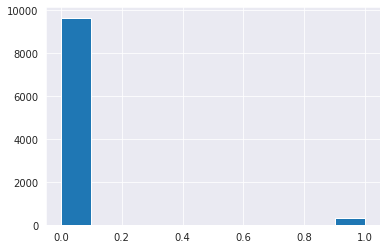

In [ ]:
data["Machine failure"].hist()

Want to change data vector to attributes that I want to use

In [ ]:
data = data.iloc[:,[3,4,5,6,7,8]]
data.head(10)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0
5,298.1,308.6,1425,41.9,11,0
6,298.1,308.6,1558,42.4,14,0
7,298.1,308.6,1527,40.2,16,0
8,298.3,308.7,1667,28.6,18,0
9,298.5,309.0,1741,28.0,21,0


See any correlations in data

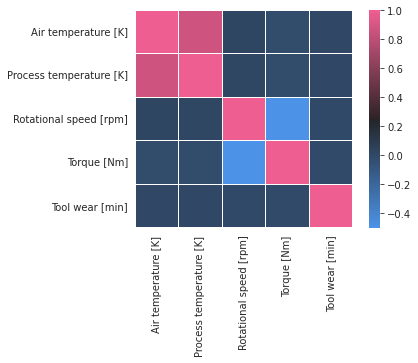

In [ ]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

airtemp and process temp are closely related, so I will exclude air temp

In [ ]:
data = data.iloc[:,[1,2,3,4,5]]
data.head(10)

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,308.6,1551,42.8,0,0
1,308.7,1408,46.3,3,0
2,308.5,1498,49.4,5,0
3,308.6,1433,39.5,7,0
4,308.7,1408,40.0,9,0
5,308.6,1425,41.9,11,0
6,308.6,1558,42.4,14,0
7,308.6,1527,40.2,16,0
8,308.7,1667,28.6,18,0
9,309.0,1741,28.0,21,0


Graph distribution of attributes

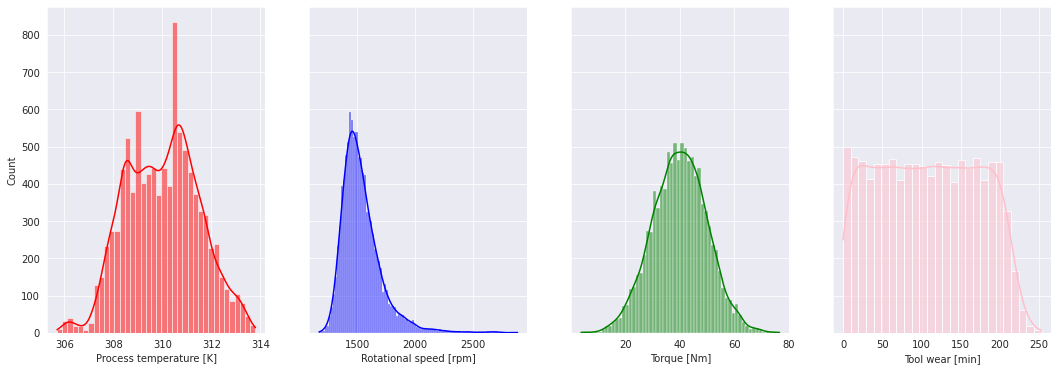

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="Process temperature [K]", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="Rotational speed [rpm]", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="Torque [Nm]", kde=True, color='g')
sns.histplot(data, ax=axes[3], x="Tool wear [min]", kde=True, color='pink')

Rotational speed and Torque are kind of normally distributed, tool wear is relatively evenly distributed, and process temperature seems to have a mix.

This data is very imbalanced as seen earlier, so we will upsample the minority and downsample the majority

In [ ]:
from sklearn.utils import resample

data_mf = data[data['Machine failure'] ==1] #minority of data
data_nomf = data[data['Machine failure'] ==0] #majority of data
print(len(data_mf))
print(len(data_nomf))

df_mf_upsample = resample(data_mf, replace=True, n_samples = 700, random_state = 123) #upsample minority up to 700 instances.
data_nomf_downsample = resample(data_nomf, replace = False, n_samples=700, random_state = 123)

data_balanced = pd.concat([df_mf_upsample, data_nomf_downsample])
data_balanced["Machine failure"].value_counts()

#create copy of balanced data for other methods
data_balanced2= pd.concat([df_mf_upsample, data_nomf_downsample])


339
9661


Calculate P(Y=y) for all possible y

In [ ]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [ ]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [ ]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

Test Gaussian model

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_balanced, test_size=.33, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="Machine failure")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

Confusion matrix shows that a large percentage are correct in prediction. F1 score is a little high but could be better. Due to the data balancing, it looks like the model isn't super great on false negatives versus false positives. 

Still, overall the model got 81% accuracy on correctness and about 0.79 for the f1 score.



# Categorical Model

In [ ]:
#Process temperature [K]	Rotational speed [rpm]	Torque [Nm]	Tool wear [min]	Machine failure
data_balanced["Cat Process temperature [K]"] = pd.cut(data_balanced["Process temperature [K]"].values, bins = 5, labels = [0,1,2,3,4])
data_balanced["Cat Rotational speed [rpm]"] = pd.cut(data_balanced["Rotational speed [rpm]"].values, bins = 5, labels = [0,1,2,3,4])
data_balanced["Cat Torque [Nm]"] = pd.cut(data_balanced["Torque [Nm]"].values, bins = 5, labels = [0,1,2,3,4])
data_balanced["Cat Tool wear [min]"] = pd.cut(data_balanced["Tool wear [min]"].values, bins = 5, labels = [0,1,2,3,4])

data_balanced= data_balanced.drop(columns=["Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"])
data_balanced = data_balanced[["Cat Process temperature [K]",	"Cat Rotational speed [rpm]",	"Cat Torque [Nm]", "Cat Tool wear [min]","Machine failure"]]
data_balanced.head(10)

Approach 2: Calculate P(X=x|Y=y) categorically

In [ ]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [ ]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

Test Categorical model

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_balanced, test_size=.33, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="Machine failure")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

Once again, the model is overall kind of accurate. It only has an overal 81% correctness on guesses (376/462). the F1 score is higher than the gaussian model but still not exceptionally high. I suspect part of this is due to the data distribution.

The categorical model did much better on false negatives but much worse on false positives

# Logistic Regression

In [ ]:
from numpy import log, dot, e
from numpy.random import rand

class LogisticRegression:
    
    def sigmoid(self, z): return 1 / (1 + e**(-z))
    
    def cost_function(self, X, y, weights):                 
        z = dot(X, weights)
        predict_1 = y * log(self.sigmoid(z))
        predict_0 = (1 - y) * log(1 - self.sigmoid(z))
        return -sum(predict_1 + predict_0) / len(X)
    
    def fit(self, X, y, epochs=25, lr=0.05):        
        loss = []
        weights = rand(X.shape[1])
        N = len(X)
                 
        for _ in range(epochs):        
            # Gradient Descent
            y_hat = self.sigmoid(dot(X, weights))
            weights -= lr * dot(X.T,  y_hat - y) / N            
            # Saving Progress
            loss.append(self.cost_function(X, y, weights)) 
            
        self.weights = weights
        self.loss = loss
    
    def predict(self, X):        
        # Predicting with sigmoid function
        z = dot(X, self.weights)
        # Returning binary result
        return [1 if i > 0.5 else 0 for i in self.sigmoid(z)]

Scaling balanced data after removing headers and reshaping as necessary

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_balanced = data_balanced2[["Process temperature [K]",	"Rotational speed [rpm]",	"Torque [Nm]", "Tool wear [min]"]]
Y_balanced = data_balanced2[["Machine failure"]]

X = X_balanced.iloc[:,:4].to_numpy() #remove headers
Y = Y_balanced.T.iloc[:].to_numpy()[0] #remove headers and turn it into just a 1D array

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.33, random_state=41)


Create Model and fit and make predictions and evaluate

In [ ]:
from sklearn.metrics import classification_report

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train, epochs=500, lr=0.005)
y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

The accuracy for this model isn't great. Probably because I am trying to find connections between attributes that are unrelated.

# NERUAL NETWORK

In [ ]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # bias_error = output_error
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

In [ ]:
print(X_balanced.shape)
print(Y_balanced.shape)
X_reshaped = np.asarray(X_balanced).reshape(X_balanced.shape[0], 1 , X_balanced.shape[1]) #convert into 3D array with shape (1400,1,4)
print(X_reshaped.shape)

Y_reshaped = np.asarray(Y_balanced).reshape(Y_balanced.shape[0], 1 , Y_balanced.shape[1]) #convert into 3D array with shape (1400,1,1) specific shape may change if I rebalance data differently
print(Y_reshaped.shape)
data_reshaped = np.asarray(data).reshape(data.shape[0], 1 , data.shape[1]) #convert into 3D array with shape (1400,1,4)
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.30, random_state=41)


In [ ]:
network = [
    FlattenLayer(input_shape=(1, 4)),
    FCLayer(1 * 4, 3),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(3, 1)
]

epochs = 40
learning_rate = 0.1

# training
for epoch in range(epochs):
    error = 0

    for x, y_true in zip(data_X_train, data_y_train):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)
            
        # error (display purpose only)
        error += mse(y_true, output)

        # backward
        output_error = mse_prime(y_true, output)
        for layer in reversed(network):
            output_error = layer.backward(output_error, learning_rate)
    
    error /= len(X_train)
    print('%d/%d, error=%f' % (epoch + 1, epochs, error))

In [ ]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

ratio = sum([np.max(y) == np.round(np.max(predict(network, x))) for x, y in zip(X_test, y_test)]) / len(X_test)
error = sum([mse(y, predict(network, x)) for x, y in zip(X_test, y_test)]) / len(X_test)
print('ratio: %.2f' % ratio)
print('mse: %.4f' % error)

In [ ]:
#print(y_test)
y_pred = []
for test, true in zip(X_test, y_test):
  pred = predict(network, test)[0]
  #print(true)
  idx = np.max(pred)
  #print(pred)
  idx_true = true[0][0]
  #idx_true = true[0][0]
  #print(true[0][0])
  #print('pred: %s, prob: %.2f, true: %d' % (np.round(idx), idx,idx_true))
  y_pred.append(np.round(idx))

#print(y_test[:,0])
print(confusion_matrix(y_test[:,0],y_pred))

This also does not have good accuracy, due to the same reason as the logistic regression: looking for connections between attributes that do not work in tandem in any way to determine the classification result.

The attributes individually (or in pairs for the room temp/process temp) can determine the classification result on their own, but this model is trying to link all of the different attributes together.